In [148]:
# Imports
%load_ext autoreload
%autoreload 2 
# !apt-get install -y xvfb
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm
import networkx as nx
from scipy import spatial
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# replace nans in angle with 0s
# !apt-get install -y xvfb
import time
import torch
import scipy
import scipy.sparse
from collections import Counter
import torch.nn as nn
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.loader import DataLoader
from torch_geometric.data import Dataset
# https://www.youtube.com/watch?v=QLIkOtKS4os --> creating custom dataset in pytorch geometric
from torch.utils.data import Dataset, random_split
import torch_geometric
from torch_geometric.data import Data, InMemoryDataset
import torch_geometric
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, GlobalAttention
from torch_geometric.nn import global_mean_pool, global_max_pool
from torch_geometric.utils import to_networkx, from_networkx
from sklearn.model_selection import StratifiedKFold
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import re
import pickle
import seaborn as sn
import random
import os

from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score

from graph_utils import set_device_and_seed, set_seed, show, visualize_graph, visualize_embedding, _count_parameters,visualise_airway_tree_matplotlib
from graph_datasets import CustomDataset
from graph_models import CustomGlobalAttention, GAT

# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib notebook


import os
import SimpleITK as sitk
# ! pip install SimpleITK==1.2.4
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import cv2
import pandas as pd
from PIL import Image
from ipywidgets import interact, fixed
from IPython.display import display
import scipy
import scipy.linalg
from scipy.spatial.transform import Rotation as R
import numpy as np
from tqdm.notebook import tqdm
# import nibabel as nib
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
%matplotlib inline
# %matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
orig_df = pd.read_csv(os.path.abspath('/home/sneha/e5_cleaned_normalised_0207.csv')) # original + weibel gen added


In [163]:
# carina_locs
def _shift_df(orig_df):
    carina_locs = orig_df.loc[orig_df.endbpid==1, ['idno', 'x','y','z']]
    carina_locs = carina_locs.rename(columns={'x':'shift_x','y':'shift_y','z':'shift_z'})
    shifted_df = orig_df.merge(carina_locs, on='idno', how='left')
    # apply shift
    shifted_df[['x','y','z']] = shifted_df[['x','y','z']].values.squeeze() - shifted_df[['shift_x','shift_y','shift_z']].values.squeeze()
    shifted_df[["parent_loc_x","parent_loc_y","parent_loc_z"]] = shifted_df[["parent_loc_x","parent_loc_y","parent_loc_z"]].values.squeeze() - shifted_df[['shift_x','shift_y','shift_z']].values.squeeze()
    # check all caaina are now 0
#     display(shifted_df.loc[shifted_df.endbpid==1, ['idno', 'x','y','z']])
    return shifted_df

shifted_df = _shift_df(orig_df)

,anatomicalname,startbpid,endbpid,x,y,z,parent_loc_x,parent_loc_y,parent_loc_z
0,Trachea,-1.0,1.0,0.000000,0.000000,0.000000,2.565859,-24.119008,-102.121099
1,LMB,1.0,3.0,31.042753,2.342853,40.414163,0.000000,0.000000,0.000000
2,RMB,1.0,2.0,-17.664000,-1.218207,18.273108,0.000000,0.000000,0.000000
3,BronInt,2.0,4.0,-30.128871,-0.676257,45.370646,-17.664000,-1.218207,18.273108
4,RUL,2.0,5.0,-31.202010,-1.862875,8.603104,-17.664000,-1.218207,18.273108
...,...,...,...,...,...,...,...,...,...
346,-,303.0,347.0,47.434592,40.293493,117.510403,50.239975,29.071958,119.614441
347,-,307.0,349.0,57.891577,-26.180389,-15.096822,54.885371,-24.977910,-11.489378
348,-,307.0,348.0,54.885371,-25.590239,-12.101707,54.885371,-24.977910,-11.489378
349,-,311.0,351.0,54.020189,-4.688372,-26.012217,53.407860,-4.688372,-26.624546


In [135]:
def _get_rot_mat(test):
    carina = test.loc[test.anatomicalname.str.lower() =='trachea', ['x', 'y', 'z']].values.squeeze()
    trachea = test.loc[test.anatomicalname.str.lower() =='trachea', ["parent_loc_x","parent_loc_y","parent_loc_z"]].values.squeeze()
    if len(carina) < 3:
        # maybe labelling not right - try another way
        carina = test.loc[test.startbpid==-1, ['x', 'y', 'z']].values.squeeze()
        assert len(carina) > 2, f'cannot find carina for {test.idno.unique()}, {carina}'
    lmb = test.loc[test.anatomicalname.str.lower() =='lmb', ['x', 'y', 'z']].values.squeeze()
    if len(lmb) < 3:
        # maybe labelling not right - try another way
        lmb = test.loc[((test.startbpid==1)& (test.anatomicalname.str.lower() != 'rmb')), ['x', 'y', 'z']].values.squeeze()
        assert len(lmb) > 2, f'cannot find lmb for {test.idno.unique()}, {lmb}'
    rmb = test.loc[test.anatomicalname.str.lower() =='rmb', ['x', 'y', 'z']].values.squeeze()
    if len(rmb) < 3:
        # maybe labelling not right - try another way
        lmb = test.loc[((test.startbpid==1)& (test.anatomicalname.str.lower() != 'lmb')), ['x', 'y', 'z']].values.squeeze()
        assert len(rmb) > 2, f'cannot find rmb for {test.idno.unique()}, {rmb}'
        
    print(carina, lmb, rmb)
    v1 = rmb - carina
    # trachea
#     v1 = carina - trachea 
    v2 = lmb - carina
    # normal to the plane containing v1 and v2 make this the z axis
    n3 = np.cross(v1, v2)
    n3 /= scipy.linalg.norm(n3)

    n2 = v1/scipy.linalg.norm(v1) # make v1 (rmb) this y axis

    #x axis is perpendicular to n3 and n2
    n1 = np.cross(n2, n3)
    n1 /= scipy.linalg.norm(n1)
    n1, n2, n3 = n1.squeeze(), n2.squeeze(), n3.squeeze()
    e1, e2, e3 = np.array([1,0,0]), np.array([0,1,0]), np.array([0,0,1])
    new_coord_sys = [n1.squeeze(), n2.squeeze(), n3.squeeze()]
    print(new_coord_sys)
    old_coord_sys = [e1, e2, e3]
#     print('new', new_coord_sys)
#     print('old', old_coord_sys)
    rot_mat = np.inner(new_coord_sys,old_coord_sys)
    return rot_mat


def _rotate_trees(df):
    
    for i, (name, participant_df) in tqdm(list(enumerate(df.groupby('idno')))):
        rot_mat = _get_rot_mat(participant_df)
        print('Rot mat', rot_mat)
        
        def _apply_transform(v):
            transformed_v =np.matmul(rot_mat, v)
            return transformed_v

        participant_df[['nx', 'ny', 'nz']] = np.apply_along_axis(_apply_transform,1, participant_df[["x","y","z"]].values.squeeze())
        participant_df[["parent_loc_nx","parent_loc_ny","parent_loc_nz"]] = np.apply_along_axis(_apply_transform,1, participant_df[["parent_loc_x","parent_loc_y","parent_loc_z"]].values.squeeze())

        if i ==0:
            df_rotated = participant_df.copy()
        else:
            df_rotated = pd.concat([df_rotated, participant_df], axis=0)
        
        print(len(df_rotated))
    return df_rotated



In [111]:
# get rotated trees
rotated_coords_df = _rotate_trees(shifted_df)
rotated_coords_df

,idno,anatomicalname,centerlinelength,avginnerarea,lobe,sublobe,endbpid,startbpid,angle,dircosx,...,dircosz_norm,shift_x,shift_y,shift_z,nx,ny,nz,parent_loc_nx,parent_loc_ny,parent_loc_nz
0,3010007,Trachea,104.96200,351.51300,0.0,0.0,1.0,-1.0,0.0000,-0.024446,...,0.986467,-2.565859,24.119008,102.121099,0.000000e+00,0.000000,0.000000e+00,7.051301e+01,-73.966214,-2.395713e+01
1,3010007,LMB,51.01420,148.68100,0.0,0.0,3.0,1.0,140.0360,0.608512,...,0.896107,-2.565859,24.119008,102.121099,-5.048029e+01,7.361171,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
2,3010007,RMB,25.44420,215.56900,0.0,0.0,2.0,1.0,134.8050,-0.694225,...,0.859082,-2.565859,24.119008,102.121099,1.776357e-15,25.444202,-3.469447e-17,0.000000e+00,0.000000,0.000000e+00
3,3010007,BronInt,29.83190,111.98300,0.0,0.0,4.0,2.0,160.3120,-0.417837,...,0.954171,-2.565859,24.119008,102.121099,-9.958142e+00,53.532154,1.358538e+00,1.776357e-15,25.444202,-3.469447e-17
4,3010007,RUL,16.64940,75.69660,3.0,0.0,5.0,2.0,98.5825,-0.813123,...,0.209599,-2.565859,24.119008,102.121099,1.645915e+01,27.928843,3.540033e-01,1.776357e-15,25.444202,-3.469447e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
884128,8024995,-,7.76122,8.59789,2.0,9.0,308.0,284.0,165.5500,-0.145479,...,0.900066,-0.516857,27.910215,88.899384,-9.708148e+01,95.060422,8.357780e+00,-9.432370e+01,88.602220,5.052816e+00
884129,8024995,-,18.25130,3.55283,2.0,9.0,309.0,285.0,172.0070,0.515058,...,0.854102,-0.516857,27.910215,88.899384,-1.331372e+02,102.242181,1.683173e+01,-1.175792e+02,95.272982,1.031340e+01
884130,8024995,-,1.06394,-1.00000,2.0,9.0,310.0,285.0,120.9650,-0.577350,...,0.788675,-0.516857,27.910215,88.899384,-1.174438e+02,96.211559,1.079580e+01,-1.175792e+02,95.272982,1.031340e+01
884131,8024995,-,9.27626,7.71677,2.0,9.0,311.0,286.0,152.5930,0.285831,...,0.957330,-0.516857,27.910215,88.899384,-1.148211e+02,98.537891,3.892702e+00,-1.078215e+02,92.556870,2.760944e+00


<IPython.core.display.Javascript object>


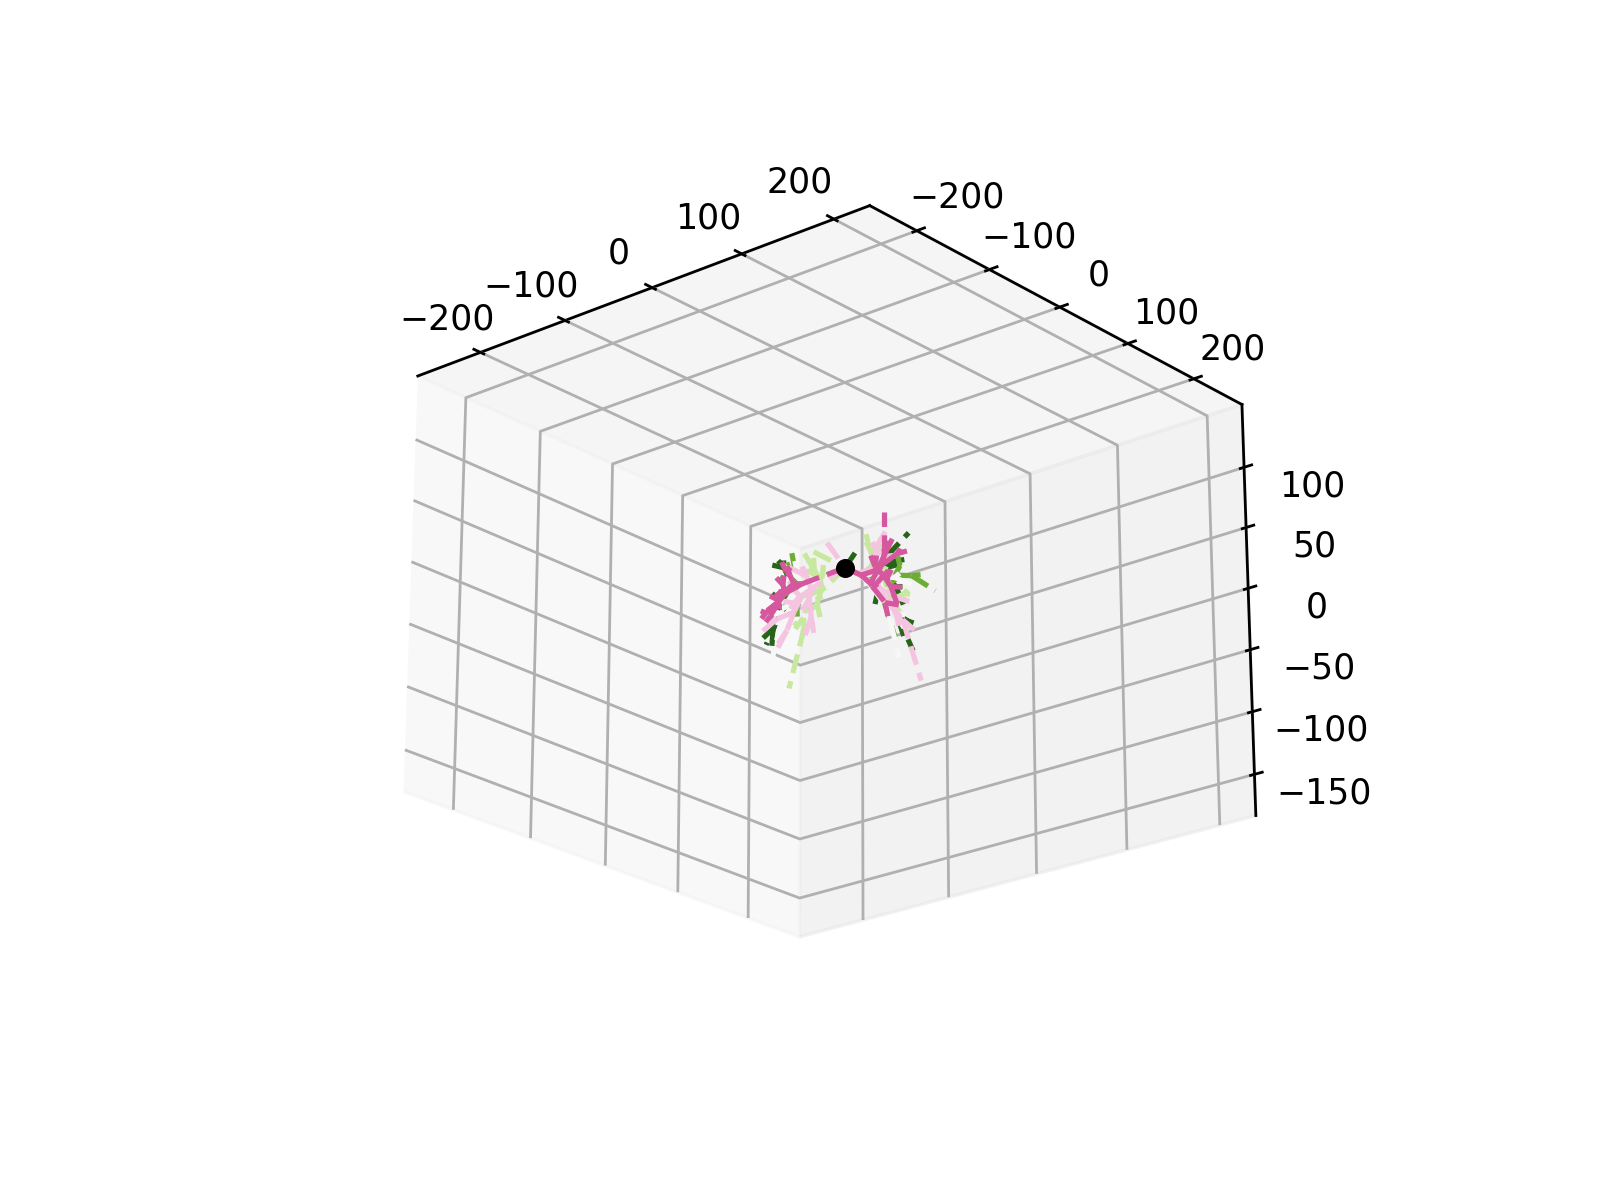

<IPython.core.display.Javascript object>


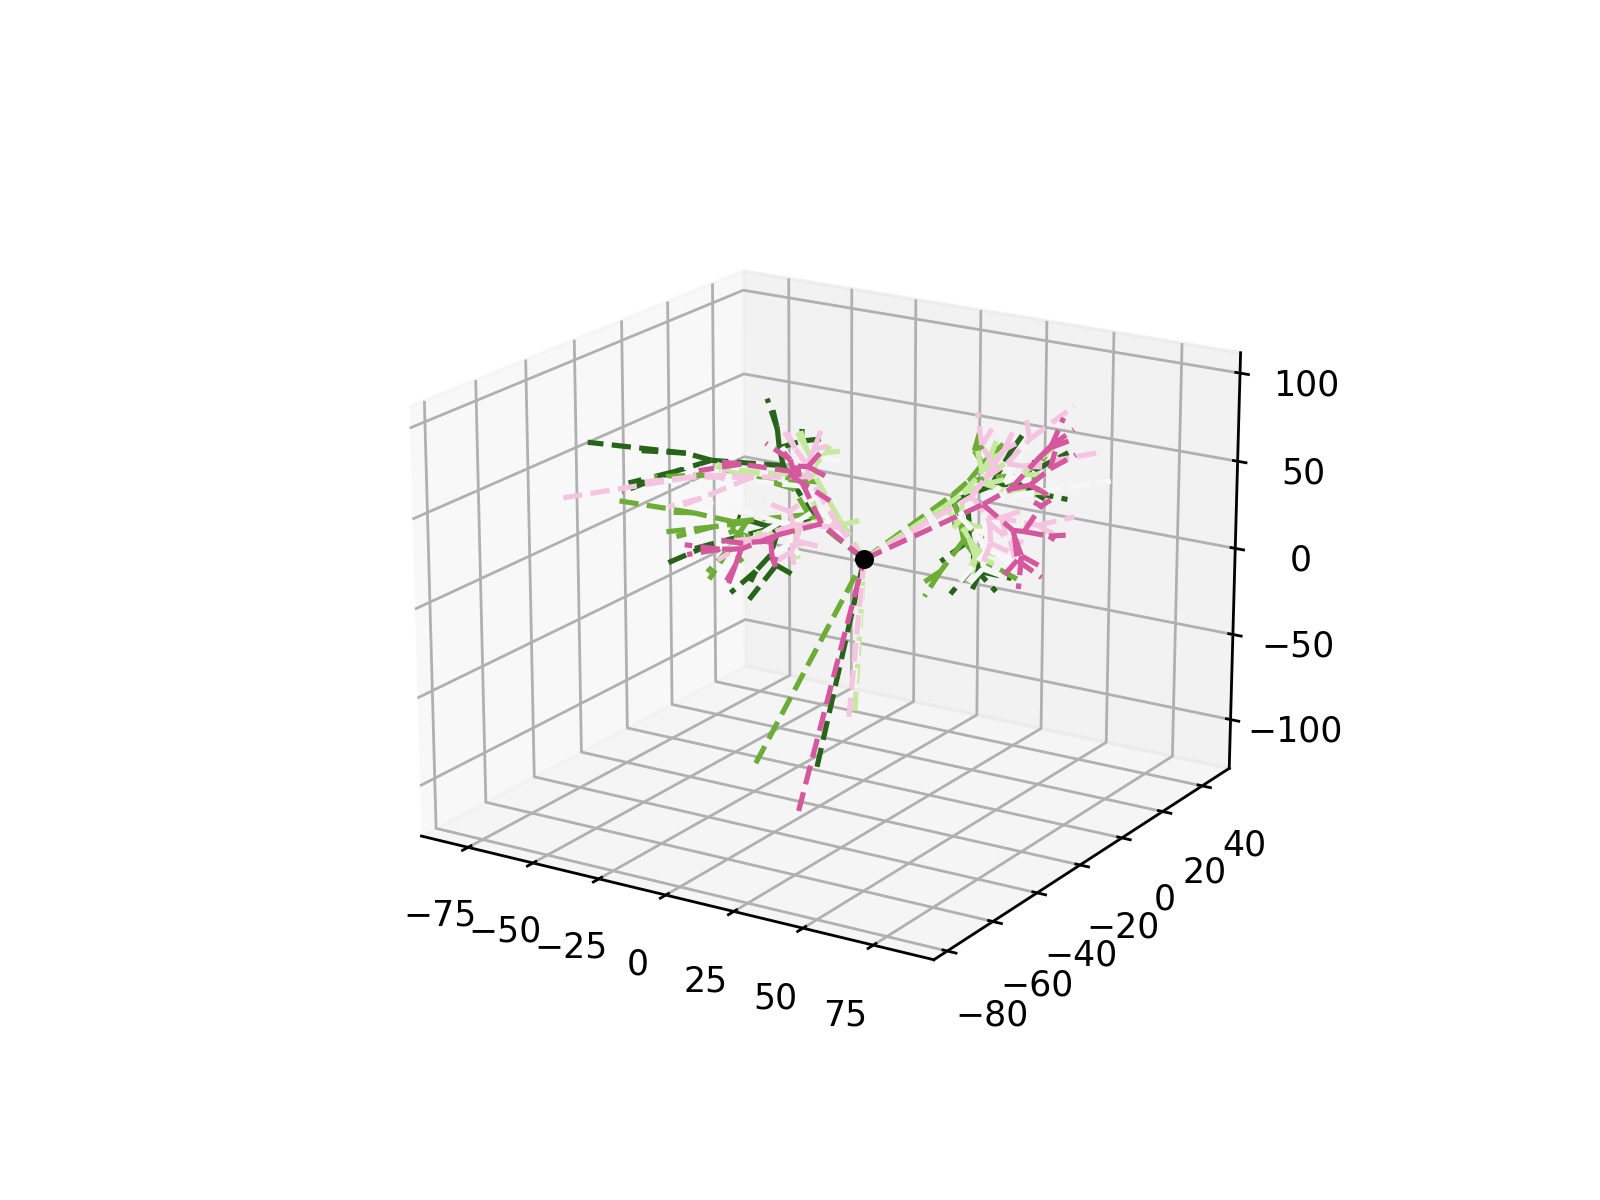

In [137]:
# visualise some rotated trees
%matplotlib notebook
val_min = 0
val_max=6
# cmap = mpl.cm.RdYlGn#.reversed()
cmap = mpl.colormaps['PiYG'].reversed()
norm = mpl.colors.Normalize(vmin=val_min, vmax=val_max)
# quick visualisation of tree

fig=plt.figure()
ax = fig.add_subplot(projection='3d')
for i, (name, participant_df) in list(enumerate(rotated_coords_df.groupby('idno')))[val_min:val_max]:
    test = participant_df.loc[participant_df.weibel_generation <=5]
    for j in range(len(test)):
        row = test.iloc[j]
#         ax.plot([row.parent_loc_x,row.x], [row.parent_loc_y,row.y], [row.parent_loc_z, row.z], linestyle='--', color='k')
        ax.plot([row.parent_loc_nx,row.nx], [row.parent_loc_ny,row.ny], [row.parent_loc_nz, row.nz], linestyle='--', color=cmap(norm(i)))

ax.scatter(0, 0, 0, marker='o', color='k', label='carina')
# plt.legend()
plt.show()


fig=plt.figure()
ax = fig.add_subplot(projection='3d')
for i, (name, participant_df) in list(enumerate(rotated_coords_df.groupby('idno')))[val_min:val_max]:
    test = participant_df.loc[participant_df.weibel_generation <=5]
    for j in range(len(test)):
        row = test.iloc[j]
        ax.plot([row.parent_loc_x,row.x], [row.parent_loc_y,row.y], [row.parent_loc_z, row.z], linestyle='--', color=cmap(norm(i)))
#         ax.plot([row.parent_loc_x,row.x], [row.parent_loc_y,row.ny], [row.parent_loc_nz, row.nz], linestyle='--', color=cmap(norm(i)))

ax.scatter(0, 0, 0, marker='o', color='k', label='carina')
# plt.legend()
plt.show()




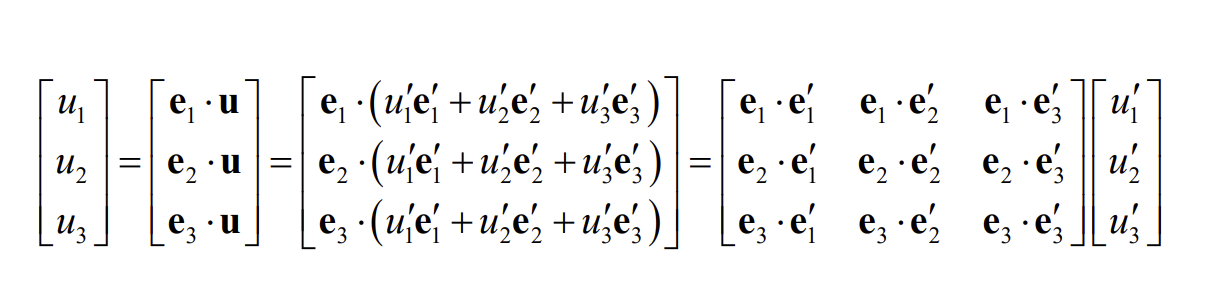

In [138]:

test = shifted_df.loc[shifted_df.idno == 3010007]
shift =  test.loc[test.endbpid==1, ['x','y','z']].values
# test[['x','y','z']]  = test[['x','y','z']].values - shift
# test[["parent_loc_x","parent_loc_y","parent_loc_z"]] =test[["parent_loc_x","parent_loc_y","parent_loc_z"]].values-shift

display(test)


rot_mat = _get_rot_mat(test)

# rot_mat = np.array([
#     [np.dot(e1,n1),np.dot(e1,n2), np.dot(e1,n3)],
#     [np.dot(e2,n1),np.dot(e2,n2), np.dot(e2,n3)],
#     [np.dot(e3,n1),np.dot(e3,n2), np.dot(e3,n3)]
#                    ])

# print(rot_mat)

# rot_mat = np.inner(new_coord_sys,old_coord_sys)

old_tree = test[['x', 'y', 'z']].values.squeeze()
old_tree.shape
def _apply_transform(v):
    transformed_v =np.matmul(rot_mat, v)
    return transformed_v

test[['nx', 'ny', 'nz']] = np.apply_along_axis(_apply_transform,1, old_tree)
test[["parent_loc_nx","parent_loc_ny","parent_loc_nz"]] = np.apply_along_axis(_apply_transform,1, test[["parent_loc_x","parent_loc_y","parent_loc_z"]].values.squeeze())
test


,idno,anatomicalname,centerlinelength,avginnerarea,lobe,sublobe,endbpid,startbpid,angle,dircosx,...,z_norm,parent_loc_x_norm,parent_loc_y_norm,parent_loc_z_norm,dircosx_norm,dircosy_norm,dircosz_norm,shift_x,shift_y,shift_z
0,3010007,Trachea,104.962000,351.51300,0.0,0.0,1.0,-1.0,0.0000,-0.024446,...,0.329993,0.476800,0.412435,0.000000,0.487777,0.614894,0.986467,-2.565859,24.119008,102.121099
1,3010007,LMB,51.014200,148.68100,0.0,0.0,3.0,1.0,140.0360,0.608512,...,0.458229,0.467000,0.508425,0.341245,0.804256,0.522963,0.896107,-2.565859,24.119008,102.121099
2,3010007,RMB,25.444200,215.56900,0.0,0.0,2.0,1.0,134.8050,-0.694225,...,0.387974,0.467000,0.508425,0.341245,0.152888,0.476061,0.859082,-2.565859,24.119008,102.121099
3,3010007,BronInt,29.831900,111.98300,0.0,0.0,4.0,2.0,160.3120,-0.417837,...,0.473956,0.399540,0.503577,0.402306,0.291081,0.509083,0.954171,-2.565859,24.119008,102.121099
4,3010007,RUL,16.649400,75.69660,3.0,0.0,5.0,2.0,98.5825,-0.813123,...,0.357291,0.399540,0.503577,0.402306,0.093438,0.480640,0.209599,-2.565859,24.119008,102.121099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,3010007,-,11.756700,5.63031,2.0,9.0,347.0,303.0,120.4570,-0.238620,...,0.702859,0.658871,0.624128,0.740946,0.380690,0.977240,0.410517,-2.565859,24.119008,102.121099
347,3010007,-,4.847360,2.83910,1.0,1.0,349.0,307.0,173.9830,0.620174,...,0.282090,0.676613,0.409017,0.302853,0.810087,0.375966,0.127896,-2.565859,24.119008,102.121099
348,3010007,-,0.865964,-1.00000,1.0,1.0,348.0,307.0,139.1070,0.000000,...,0.291594,0.676613,0.409017,0.302853,0.500000,0.146446,0.146446,-2.565859,24.119008,102.121099
349,3010007,-,0.865964,-1.00000,1.0,2.0,351.0,311.0,36.5868,0.707107,...,0.247455,0.670970,0.489766,0.252277,0.853554,0.500000,0.853554,-2.565859,24.119008,102.121099


[0. 0. 0.] [31.04275287  2.34285264 40.41416344] [-17.66399974  -1.21820723  18.27310845]
[array([-0.7161818 , -0.05339288, -0.6958684 ]), array([-0.69422495, -0.0478776 ,  0.71816395]), array([-0.07166135,  0.99742515, -0.00277761])]


/tmp/ipykernel_27917/251629712.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[['nx', 'ny', 'nz']] = np.apply_along_axis(_apply_transform,1, old_tree)
/tmp/ipykernel_27917/251629712.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[['nx', 'ny', 'nz']] = np.apply_along_axis(_apply_transform,1, old_tree)
/tmp/ipykernel_27917/251629712.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

,idno,anatomicalname,centerlinelength,avginnerarea,lobe,sublobe,endbpid,startbpid,angle,dircosx,...,dircosz_norm,shift_x,shift_y,shift_z,nx,ny,nz,parent_loc_nx,parent_loc_ny,parent_loc_nz
0,3010007,Trachea,104.962000,351.51300,0.0,0.0,1.0,-1.0,0.0000,-0.024446,...,0.986467,-2.565859,24.119008,102.121099,0.000000e+00,0.000000,0.000000e+00,7.051301e+01,-73.966214,-2.395713e+01
1,3010007,LMB,51.014200,148.68100,0.0,0.0,3.0,1.0,140.0360,0.608512,...,0.896107,-2.565859,24.119008,102.121099,-5.048029e+01,7.361171,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
2,3010007,RMB,25.444200,215.56900,0.0,0.0,2.0,1.0,134.8050,-0.694225,...,0.859082,-2.565859,24.119008,102.121099,1.776357e-15,25.444202,-3.469447e-17,0.000000e+00,0.000000,0.000000e+00
3,3010007,BronInt,29.831900,111.98300,0.0,0.0,4.0,2.0,160.3120,-0.417837,...,0.954171,-2.565859,24.119008,102.121099,-9.958142e+00,53.532154,1.358538e+00,1.776357e-15,25.444202,-3.469447e-17
4,3010007,RUL,16.649400,75.69660,3.0,0.0,5.0,2.0,98.5825,-0.813123,...,0.209599,-2.565859,24.119008,102.121099,1.645915e+01,27.928843,3.540033e-01,1.776357e-15,25.444202,-3.469447e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,3010007,-,11.756700,5.63031,2.0,9.0,347.0,303.0,120.4570,-0.238620,...,0.410517,-2.565859,24.119008,102.121099,-1.178950e+02,49.532302,3.646412e+01,-1.207691e+02,49.633039,2.506460e+01
347,3010007,-,4.847360,2.83910,1.0,1.0,349.0,307.0,173.9830,0.620174,...,0.127896,-2.565859,24.119008,102.121099,-2.955765e+01,-49.778316,-3.021963e+01,-2.997917e+01,-45.158168,-2.881484e+01
348,3010007,-,0.865964,-1.00000,1.0,1.0,348.0,307.0,139.1070,0.000000,...,0.146446,-2.565859,24.119008,102.121099,-2.952037e+01,-45.568604,-2.942389e+01,-2.997917e+01,-45.158168,-2.881484e+01
349,3010007,-,0.865964,-1.00000,1.0,2.0,351.0,311.0,36.5868,0.707107,...,0.853554,-2.565859,24.119008,102.121099,-2.033687e+01,-55.958732,-8.475208e+00,-1.947223e+01,-55.973390,-8.429627e+00


<IPython.core.display.Javascript object>


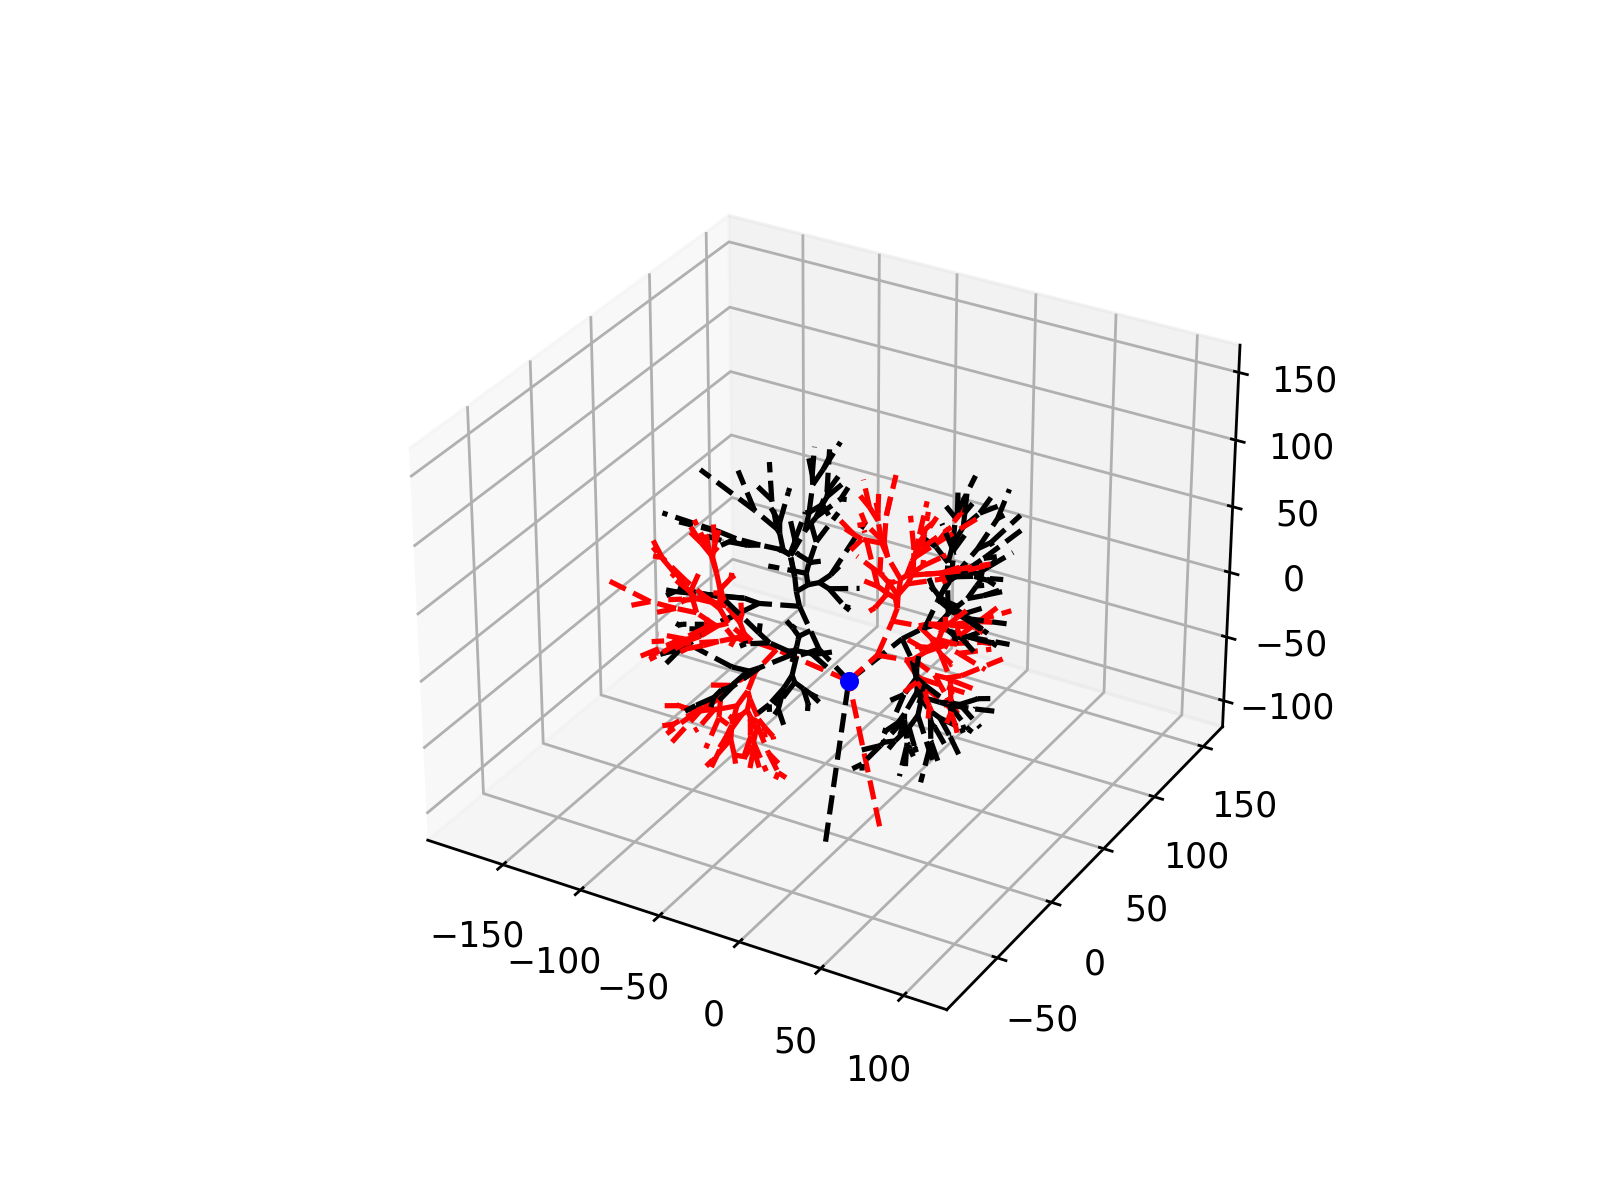

In [139]:

# quick visualisation of tree

fig=plt.figure()
ax = fig.add_subplot(projection='3d')
for i in range(len(test)):
    row = test.iloc[i]
    ax.plot([row.parent_loc_x,row.x], [row.parent_loc_y,row.y], [row.parent_loc_z, row.z], linestyle='--', color='k')
    ax.plot([row.parent_loc_nx,row.nx], [row.parent_loc_ny,row.ny], [row.parent_loc_nz, row.nz], linestyle='--', color='r')

ax.scatter(0, 0, 0, marker='o', color='b', label='carina')
# plt.legend()
plt.show()

In [140]:
# check lengths are still the same - YES
scipy.linalg.norm(test.iloc[0][["parent_loc_nx","parent_loc_ny","parent_loc_nz"]].values.squeeze()), scipy.linalg.norm(test.iloc[0][["parent_loc_x","parent_loc_y","parent_loc_z"]].values.squeeze())

(104.9620357216778, 104.9620357216778)

<IPython.core.display.Javascript object>


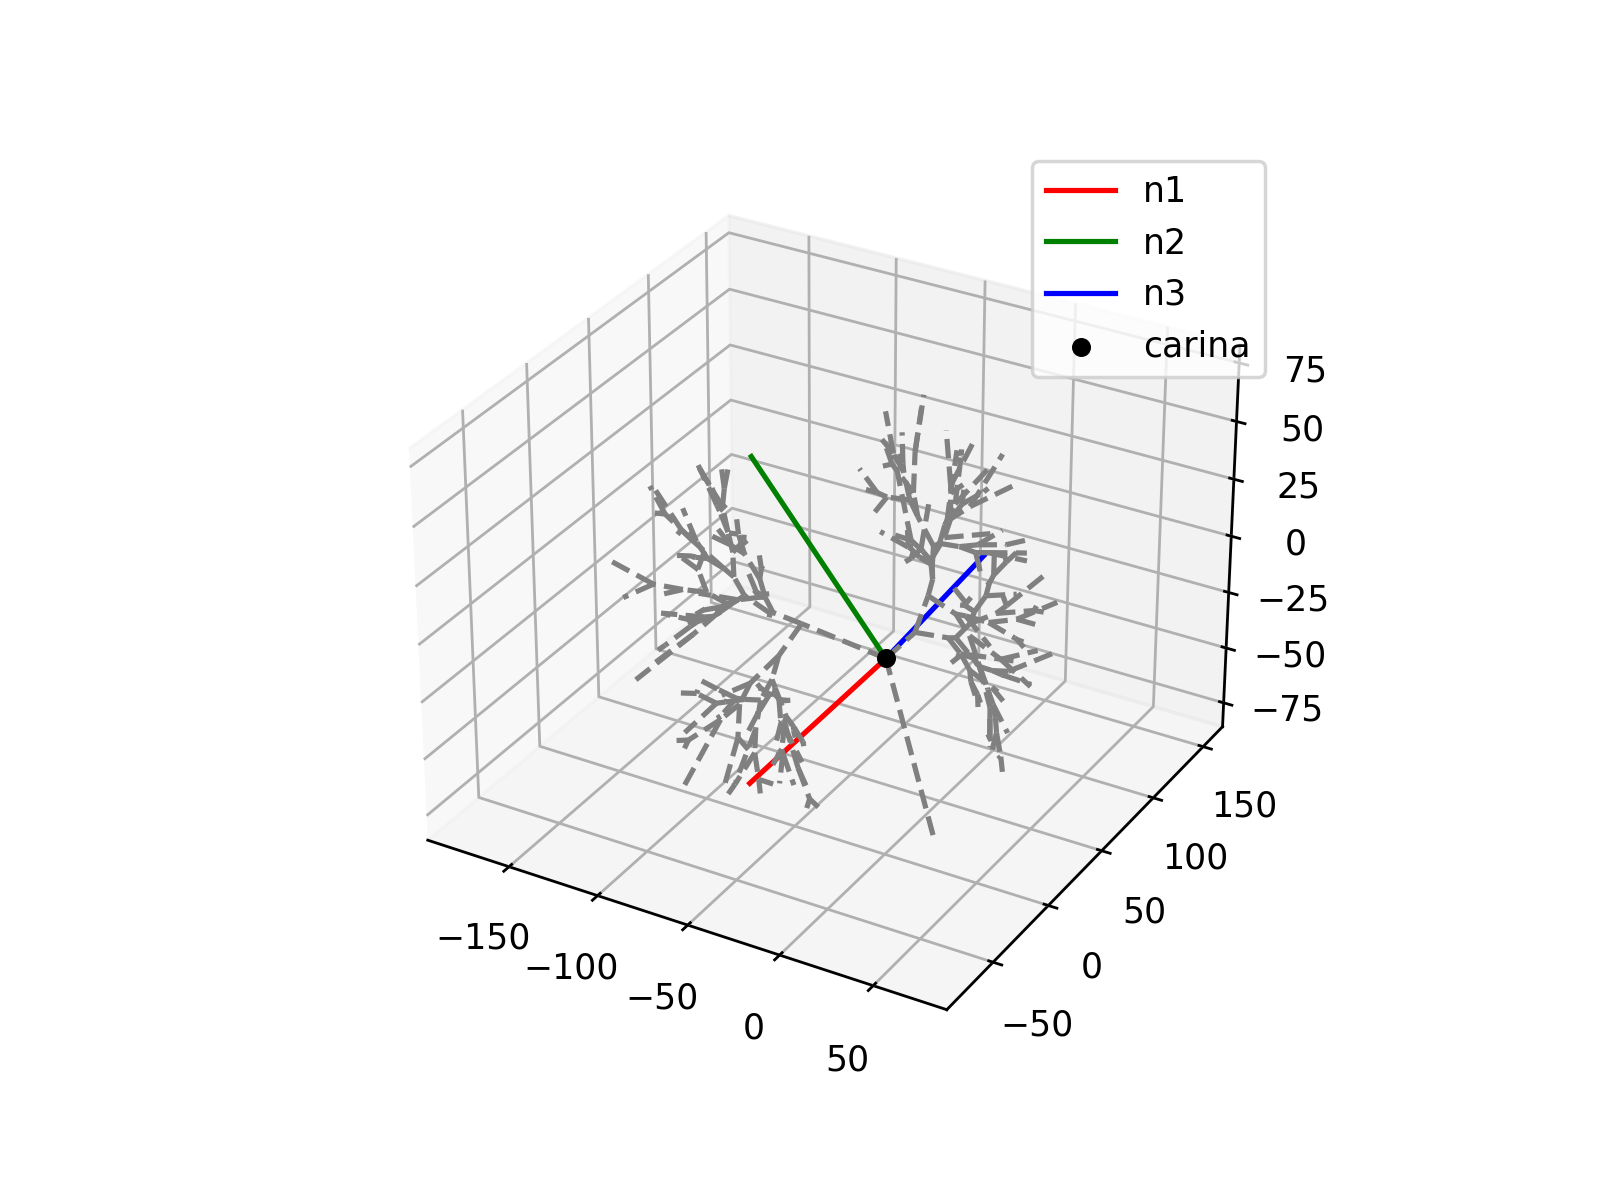

In [142]:
# plot axes and tree

colors = ['r', 'g', 'b']
fig=plt.figure()
ax = fig.add_subplot(projection='3d')
for i in range(len(new_coord_sys)):
    ax.plot([0,100*new_coord_sys[i][0]], [0,100*new_coord_sys[i][1]], [0,100*new_coord_sys[i][2]], linestyle='-',color=colors[i], label=f'n{i+1}')

for i in range(len(test)):
    row = test.iloc[i]
    ax.plot([row.parent_loc_nx,row.nx], [row.parent_loc_ny,row.ny], [row.parent_loc_nz, row.nz], linestyle='--', color='grey')

ax.scatter(0, 0, 0, marker='o', color='k', label='carina')

plt.legend()
plt.show()



/tmp/ipykernel_27917/291292303.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[['nxt', 'nyt', 'nzt']] = normaliser_minmax.transform(test[['nx', 'ny', 'nz']].values)
/tmp/ipykernel_27917/291292303.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[["parent_loc_nxt","parent_loc_nyt","parent_loc_nzt"]] = normaliser_minmax.transform(test[["parent_loc_nx","parent_loc_ny","parent_loc_nz"]].values)


<IPython.core.display.Javascript object>


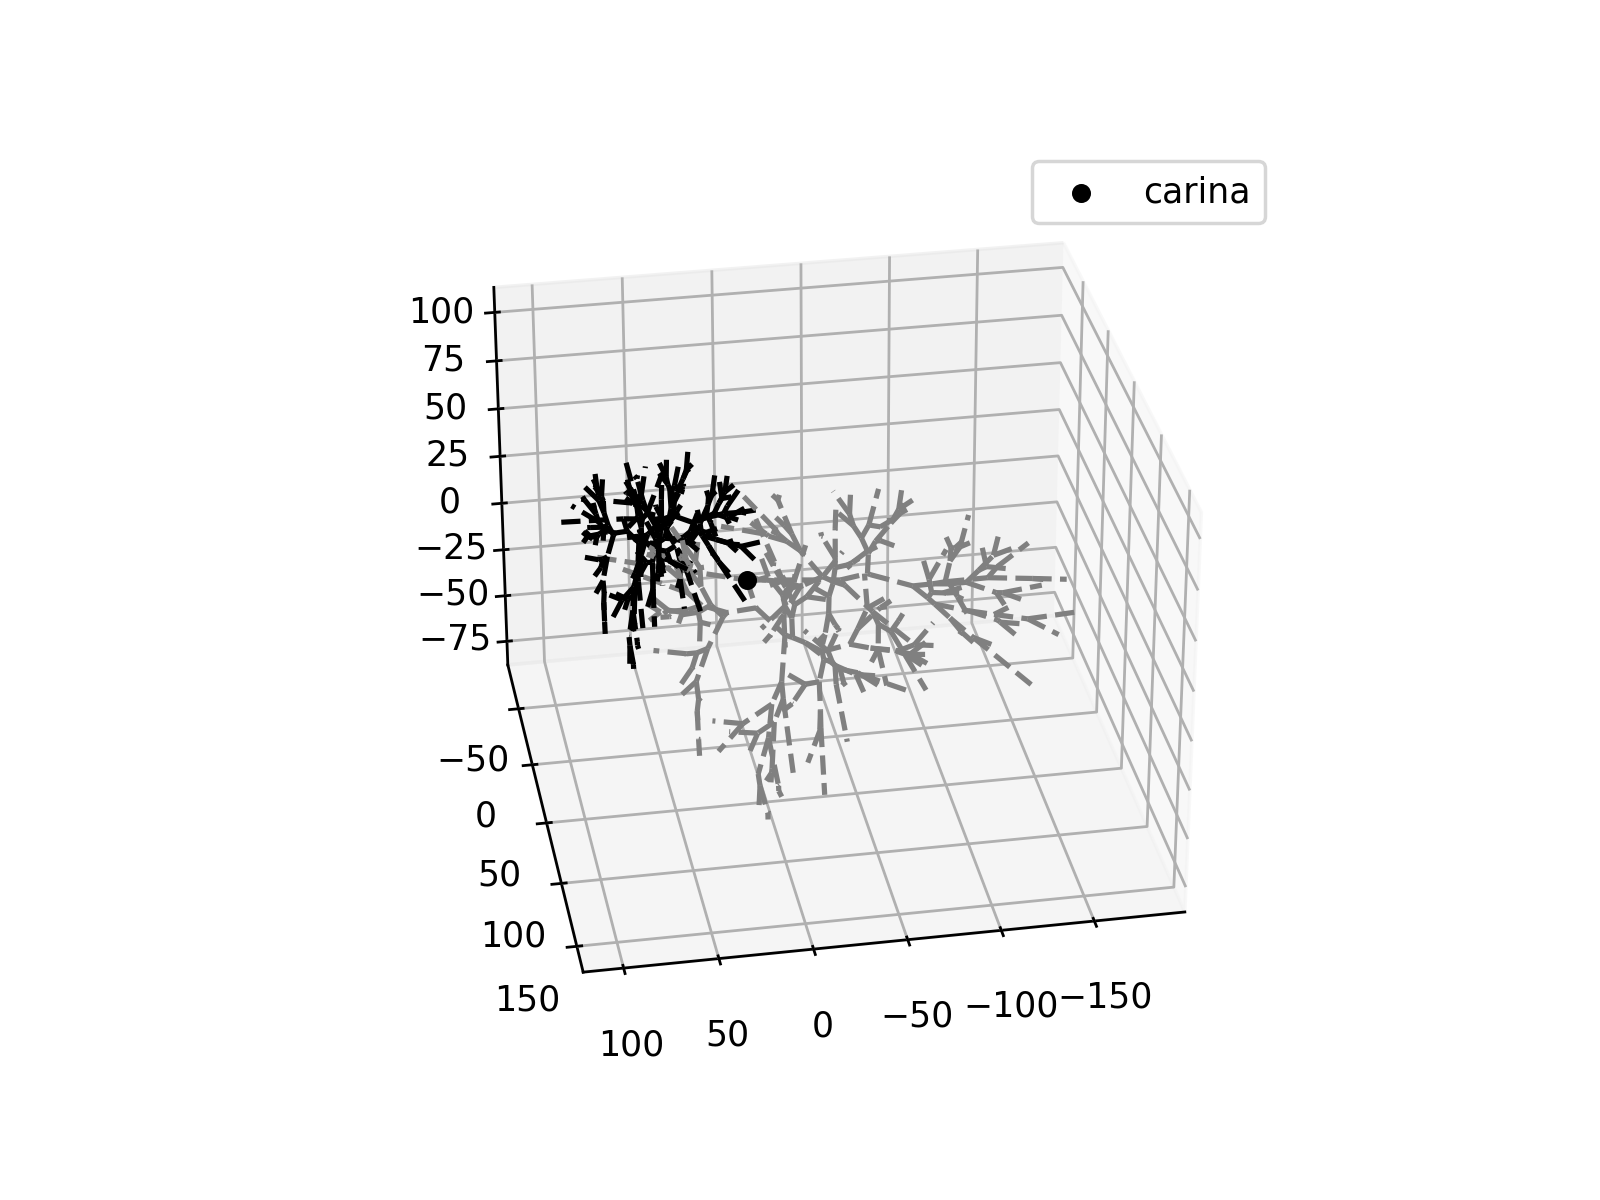

In [162]:
# scaling bounding box
%matplotlib notebook
data_to_scale_0_1 = test[['nx', 'ny', 'nz']]
normaliser_minmax = MinMaxScaler(feature_range=(0,100))
normaliser_minmax.fit(data_to_scale_0_1.values)
test[['nxt', 'nyt', 'nzt']] = normaliser_minmax.transform(test[['nx', 'ny', 'nz']].values)
test[["parent_loc_nxt","parent_loc_nyt","parent_loc_nzt"]] = normaliser_minmax.transform(test[["parent_loc_nx","parent_loc_ny","parent_loc_nz"]].values)

test

# plot axes and tree

colors = ['r', 'g', 'b']
fig=plt.figure()
ax = fig.add_subplot(projection='3d')

for i in range(len(test)):
    row = test.iloc[i]
    ax.plot([row.parent_loc_nx,row.nx], [row.parent_loc_ny,row.ny], [row.parent_loc_nz, row.nz], linestyle='--', color='grey')
    ax.plot([row.parent_loc_nxt,row.nxt], [row.parent_loc_nyt,row.nyt], [row.parent_loc_nzt, row.nzt], linestyle='--', color='k')

ax.scatter(0, 0, 0, marker='o', color='k', label='carina')

plt.legend()
plt.show()